<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/mlops/profit-curves/stocking-problem-synthetic-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook demonstrates the following.

- Define products with costs, potential prices, and demand sensitivities.
- Simulate purchase probabilities as a function of price.
- Compute expected profit across a price range for each product.
- Plot profit curves to visualize optimal pricing strategies.

## Dataset Description

The dataset represents **transaction-level data** for 5 years, including weekend discounting, sales, and profit for three different products.
## Dataset Description

This dataset simulates product sales over a 5-year period, incorporating factors such as pricing, discounts, product elasticity, customer purchase behavior, and daily transactions.

### Key Features:
1. **Product Profiles**:
   Each product is characterized by:
   - **Cost**: The manufacturing or acquisition cost.
   - **Price**: The base price of the product before any discounts.
   - **Base Demand**: The baseline number of purchases for the product.
   - **Elasticity**: A measure of how demand changes with respect to price adjustments. A negative elasticity value indicates demand decreases as price increases.

2. **Discounts**:
   - **Weekend Discount**: A 25% discount is applied to products purchased on weekends.
   - **Premium Customer Discount**: A 10% discount is applied to products purchased by premium customers. 20% of customers are considered premium.
   - **Final Discounted Price**: The product price is adjusted based on the weekend discount and premium customer discount.

3. **Demand Calculation**:
   - **Adjusted Demand**: The demand for a product is adjusted based on its price elasticity. The formula for demand is:
     ```
     Adjusted Demand = Base Demand * (1 + Elasticity * (1 - Price Ratio))
     ```
   - **Price Ratio**: The ratio of the discounted price to the base price.
   - **Demand Adjustment**: The demand decreases with an increase in price (negative elasticity) and increases with a decrease in price.

4. **Purchase Probability**:
   - **Purchase Probability Formula**:
     ```
     Purchase Probability = Adjusted Demand / (Base Demand * 2)
     ```
   - **Premium Customers**: Premium customers are more likely to purchase, with a fixed purchase probability of 75%.

5. **Purchases**:
   - **Purchase Decision**: A random number is compared to the purchase probability to decide whether a purchase occurs.
   - **Revenue**: If a product is purchased, the revenue is the discounted price; otherwise, it is 0.
   - **Expense**: The expense is equal to the product’s cost if purchased, and 0 otherwise.
   - **Profit**: Profit is calculated as revenue minus expense.

6. **Non-Purchasing Visitors**:
   - 20% of the data is generated for non-purchasing visitors, with no revenue, expense, or profit.
   - These rows simulate users who browse but do not purchase.

7. **Date Generation**:
   - The dataset spans **5 years** of transactions starting from **January 1, 2025**.
   - The transactions are generated daily, with weekends treated differently due to discounts.

8. **Sorting and Data Preparation**:
   - The data is sorted by the timestamp to ensure the transactions are in chronological order.

---

Below is the description of each column:


| **Column Name**     | **Description**                                                                                      | **Example**                          |
|---------------------|------------------------------------------------------------------------------------------------------|--------------------------------------|
| **timestamp**       | The date when the transaction occurred.                                                               | 2025-01-01                           |
| **product**         | The product identifier (ASCII value of the product character, e.g., 'A' becomes 65).                 | 65 (for product 'A')                 |
| **cost**            | The cost price of the product.                                                                        | 20.0                                 |
| **base_price**      | The original price of the product before any discount is applied.                                     | 30.0                                 |
| **price**           | The final price after considering any discount (if applicable).                                       | 22.5 (after a 25% weekend discount)  |
| **base_demand**     | The base demand for the product (before any price elasticity adjustments).                            | 50                                   |
| **elasticity**      | The price elasticity of demand, which measures how demand changes with respect to price changes.       | -1.5                                 |
| **purchase_prob**   | The probability that a customer purchases the product based on demand, elasticity, and other factors.  | 0.8                                  |
| **purchased**       | A binary indicator (0 or 1) that shows whether the product was purchased or not.                      | 1 (if purchased) / 0 (if not)        |
| **revenue**         | The revenue generated from the purchase (calculated as price * purchased).                            | 22.5 (if purchased)                  |
| **expense**         | The cost incurred for the product (calculated as cost * purchased).                                   | 20.0 (if purchased)                  |
| **profit**          | The profit generated from the purchase (calculated as revenue - expense).                            | 2.5                                  |
| **is_weekend**      | A binary indicator (True or False) that shows whether the transaction happened on a weekend.          | True (if weekend) / False (if not)   |
| **is_premium**      | A binary indicator (True or False) that shows whether the purchase is from a premium customer (if applicable). | True (if premium) / False (if not)    |


In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

# Set seed for reproducibility
np.random.seed(42)

# Define product profiles
products = {
    "A": {"cost": 20.0, "price": 30.0, "base_demand": 50, "elasticity": 1.5},
    "B": {"cost": 5.0, "price": 7.0, "base_demand": 200, "elasticity": 0.5},
    "C": {"cost": 30.0, "price": 33.0, "base_demand": 180, "elasticity": 1.0},
    "D": {"cost": 15.0, "price": 25.0, "base_demand": 120, "elasticity": 1.3},
    "E": {"cost": 10.0, "price": 12.0, "base_demand": 220, "elasticity": 0.7},
    "F": {"cost": 50.0, "price": 70.0, "base_demand": 40, "elasticity": 1.7},
    "G": {"cost": 8.0, "price": 10.0, "base_demand": 250, "elasticity": 0.4},
    "H": {"cost": 12.0, "price": 18.0, "base_demand": 160, "elasticity": 1.1},
    "I": {"cost": 25.0, "price": 40.0, "base_demand": 90, "elasticity": 1.4},
    "J": {"cost": 18.0, "price": 28.0, "base_demand": 130, "elasticity": 1.2}
}

# Parameters
NUM_DAYS = 5*365
WEEKEND_DISCOUNT = 0.25
NON_PURCHASE_RATIO = 0.2

# Generate dates
start_date = datetime(2025, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(NUM_DAYS)]

# Generate transactions
data = []
for date in dates:
    is_weekend = date.weekday() >= 5
    multiplier = 1.5 if is_weekend else 1.0

    for product, profile in products.items():
        demand = int(profile["base_demand"] * multiplier)

        for _ in range(demand):
            base_price = profile["price"]
            is_premium = np.random.rand() < 0.2
            discount = (WEEKEND_DISCOUNT if is_weekend else 0) + (0.1 if is_premium else 0)
            discount_price = base_price * (1 - discount)
            price_ratio = discount_price / base_price
            elasticity = profile["elasticity"]
            adjusted_demand = profile["base_demand"] * (1 + elasticity * (1 - price_ratio))
            adjusted_demand = max(adjusted_demand, 0)
            purchase_prob = adjusted_demand / max(1, profile["base_demand"] * 2)
            discount_price = max(discount_price, 0)

            if is_premium:
                purchase_prob = 0.75

            purchased = np.random.rand() < purchase_prob
            revenue = discount_price if purchased else 0
            expense = profile["cost"] if purchased else 0
            profit = revenue - expense

            data.append({
                "timestamp": date,
                "product": ord(product),
                "cost": profile["cost"],
                "base_price": base_price,
                "price": discount_price,
                "base_demand": profile["base_demand"],
                "elasticity": profile["elasticity"],
                "purchase_prob": purchase_prob,
                "purchased": int(purchased),
                "revenue": revenue,
                "expense": expense,
                "profit": profit,
                "is_weekend": is_weekend,
                "is_premium": is_premium,
            })

# Create DataFrame
df_txn = pd.DataFrame(data)

# Add 20% non-purchasing visitors - add jitter into dataset
n_non_buyers = int(NON_PURCHASE_RATIO * len(df_txn))
non_buyer_rows = df_txn.sample(n=n_non_buyers, replace=True).copy()
non_buyer_rows["purchased"] = 0
non_buyer_rows["price"] = 0
non_buyer_rows["revenue"] = 0
non_buyer_rows["expense"] = 0
non_buyer_rows["profit"] = 0
non_buyer_rows["purchase_prob"] = 0.0
non_buyer_rows["is_premium"] = False

# Combine and sort
df_txn = pd.concat([df_txn, non_buyer_rows], ignore_index=True)
df_txn.sort_values("timestamp", inplace=True)
df_txn.reset_index(drop=True, inplace=True)

# View sample
df_txn.head()


,timestamp,product,cost,base_price,price,base_demand,elasticity,purchase_prob,purchased,revenue,expense,profit,is_weekend,is_premium
0,2025-01-01,65,20.0,30.0,30.0,50,1.5,0.50,0,0.0,0.0,0.0,False,False
1,2025-01-01,72,12.0,18.0,16.2,160,1.1,0.75,1,16.2,12.0,4.2,False,True
2,2025-01-01,72,12.0,18.0,18.0,160,1.1,0.50,1,18.0,12.0,6.0,False,False
3,2025-01-01,72,12.0,18.0,16.2,160,1.1,0.75,1,16.2,12.0,4.2,False,True
4,2025-01-01,72,12.0,18.0,18.0,160,1.1,0.50,0,0.0,0.0,0.0,False,False


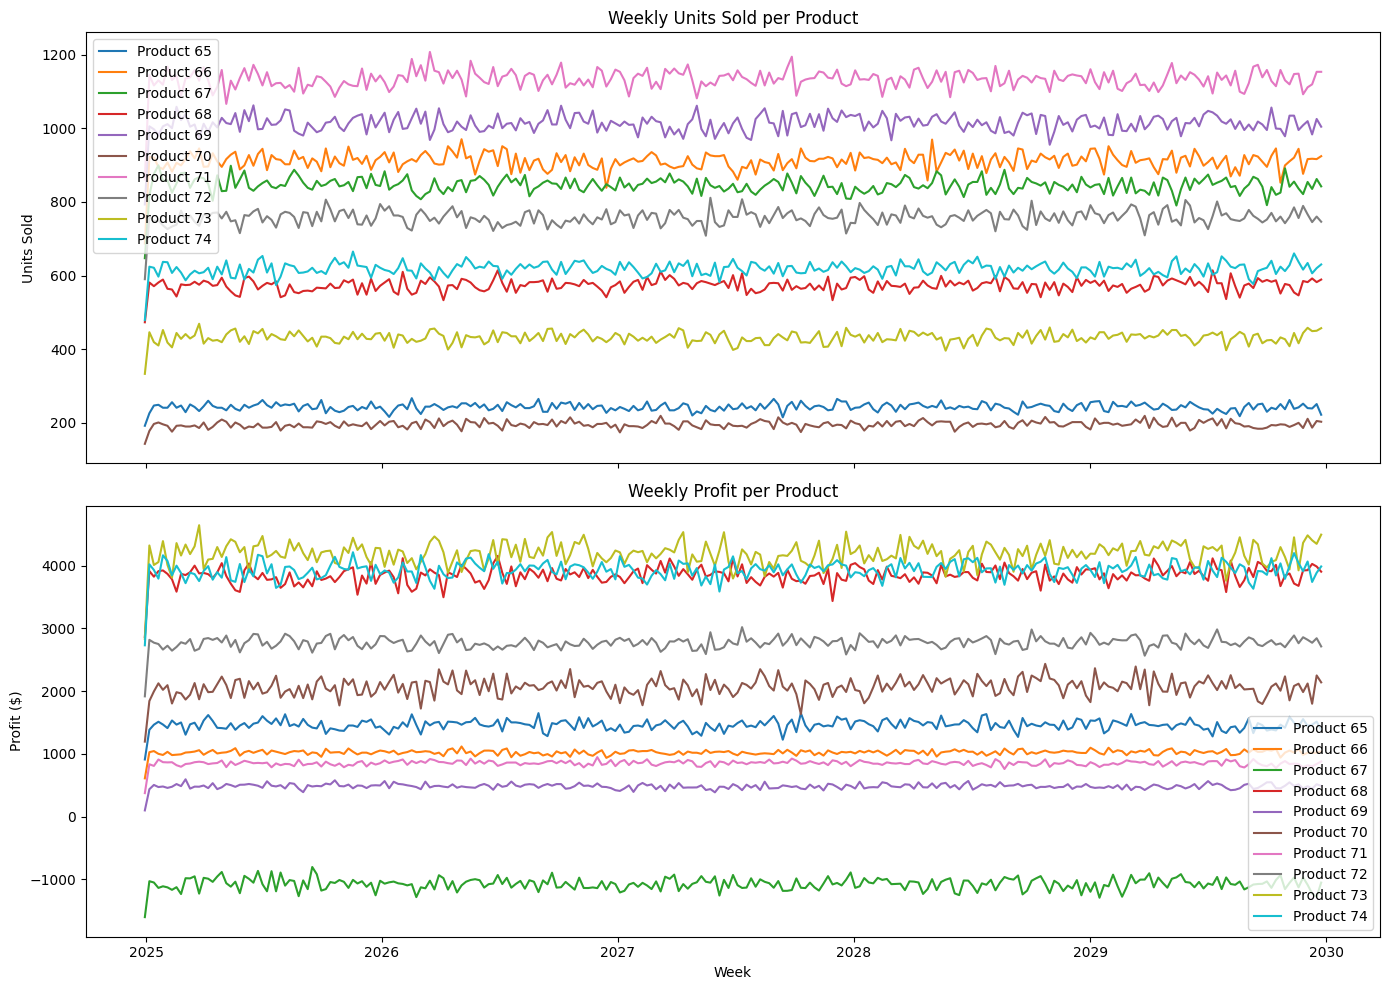

In [2]:
import matplotlib.pyplot as plt

# Ensure 'timestamp' is datetime and add 'week' column
df_txn["week"] = df_txn["timestamp"].dt.to_period("W").apply(lambda r: r.start_time)

# Aggregate: weekly units sold and profit per product
weekly_summary = df_txn[df_txn["purchased"] == 1].groupby(["week", "product"]).agg({
    "purchased": "count",
    "profit": "sum"
}).rename(columns={"purchased": "units_sold"}).reset_index()

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Units Sold Plot
for product in weekly_summary["product"].unique():
    product_data = weekly_summary[weekly_summary["product"] == product]
    axs[0].plot(product_data["week"], product_data["units_sold"], label=f"Product {product}")

axs[0].set_title("Weekly Units Sold per Product")
axs[0].set_ylabel("Units Sold")
axs[0].legend()

# Profit Plot
for product in weekly_summary["product"].unique():
    product_data = weekly_summary[weekly_summary["product"] == product]
    axs[1].plot(product_data["week"], product_data["profit"], label=f"Product {product}")

axs[1].set_title("Weekly Profit per Product")
axs[1].set_ylabel("Profit ($)")
axs[1].set_xlabel("Week")
axs[1].legend()

plt.tight_layout()
plt.show()


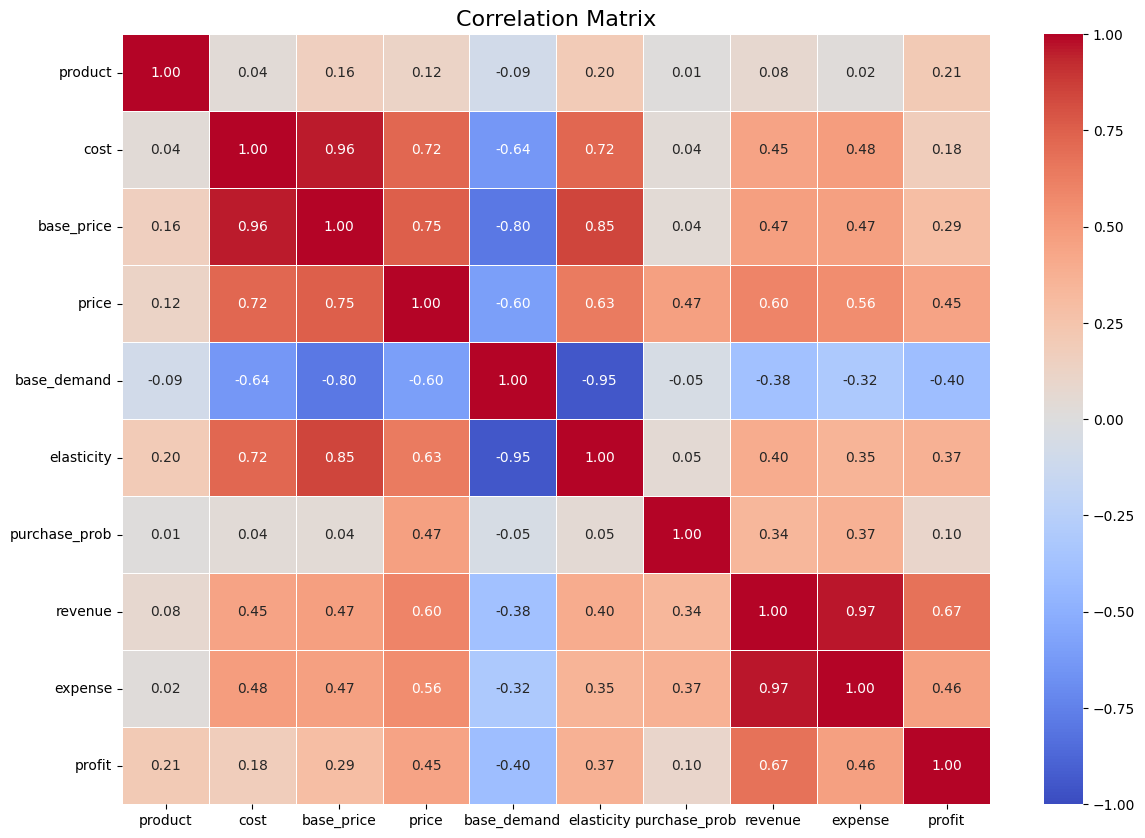

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
X = df_txn.drop(columns=['purchased', 'timestamp', 'week'])
corr_matrix = X.select_dtypes(include=['number']).corr()

# Plot the larger correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [4]:
df_txn.to_csv("synthetic_stocking_dataset.csv", index=False)
df_model = df_txn

In [10]:
!ls -larth synthetic_stocking_dataset*

-rw-r--r-- 1 root root 275M May  2 12:22 synthetic_stocking_dataset.csv


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vadhri-venkat to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,1
f1_score,1
precision,1
recall,1


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,1
f1_score,1
precision,1
recall,1


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,1
f1_score,1
precision,1
recall,1


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,1
f1_score,1
precision,1
recall,1


accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,1
f1_score,1
precision,1
recall,1


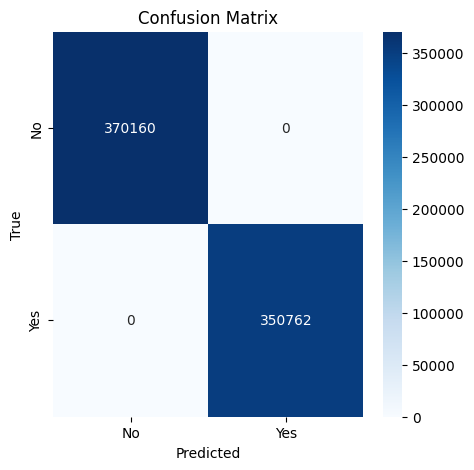

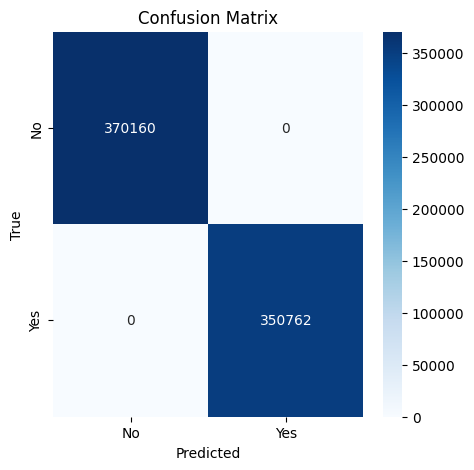

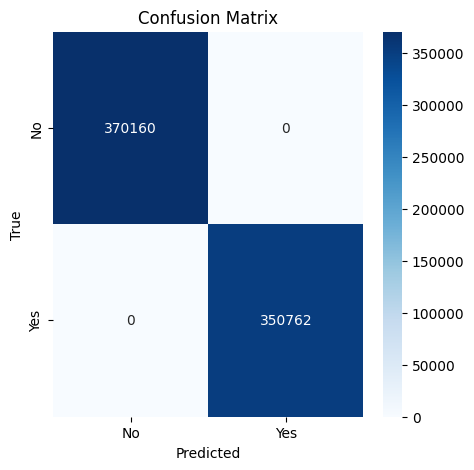

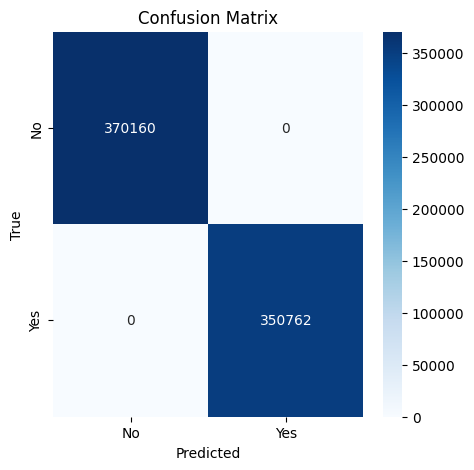

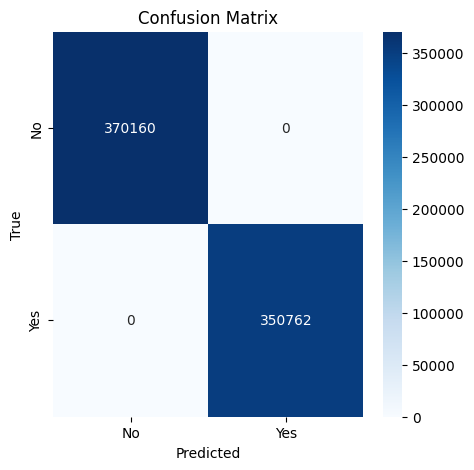

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import KNeighborsClassifier

# Initialize wandb
wandb.login()

# Define classifiers to try
models = {
    "LogisticRegression": LogisticRegression(max_iter=10),
    "RandomForest": RandomForestClassifier(n_estimators=10, random_state=42),
    "SVM": SVC(C=1.0, kernel='rbf', max_iter=10,probability=True),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}

# Add the PyTorch Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

# Assuming df_model is already prepared
target = "purchased"

# Apply label encoding to 'product' column

X = df_model.drop(columns=['purchased', 'timestamp', 'week'])
y = df_model[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors for NN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Add the neural network to models
models["NeuralNetwork"] = SimpleNN(X_train.shape[1])

# Run experiments
for model_name, model in models.items():
    with wandb.init(project="stocking-classification", name=model_name, reinit=True):
        if model_name == "NeuralNetwork":
            # Define loss function and optimizer for NN
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            # Training loop for NN
            num_epochs = 10
            for epoch in range(num_epochs):
                model.train()
                optimizer.zero_grad()
                output = model(X_train_tensor)
                loss = criterion(output, y_train_tensor)
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 100 == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

            # Evaluate the model on the test set
            model.eval()
            with torch.no_grad():
                y_pred = model(X_test_tensor)
                y_pred = (y_pred > 0.5).float()

            # Convert the predictions back to a NumPy array
            y_pred = y_pred.numpy().flatten()

        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Log metrics
        wandb.log({
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='binary'),
            "recall": recall_score(y_test, y_pred, average='binary'),
            "f1_score": f1_score(y_test, y_pred, average='binary')
        })

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title('Confusion Matrix')

        # Log confusion matrix as an image to wandb
        wandb.log({"confusion_matrix": wandb.Image(fig)})

        wandb.finish()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Axes: >

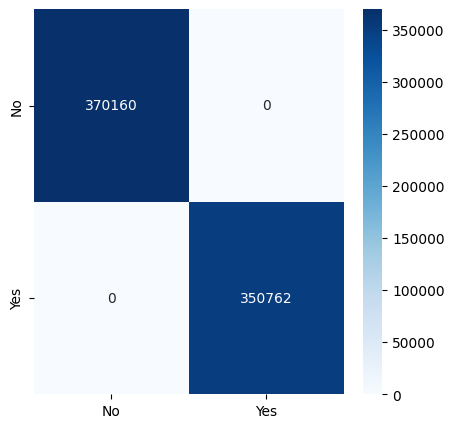

In [8]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric="logloss"))  # XGBoost classifier
])

# Example usage (assuming X_train and y_train are defined)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# add confusion matix
cm = confusion_matrix(y_test, y_pred)

#plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])